In [29]:
import pandas as pd
import numpy as np
import torch
from dataset import ClimateDatasetV2A
with open("../climate_washed/static_filtered.csv", "r") as f:
    stations = pd.read_csv(f)

targets = ["00010", "00095", "00300", "00400", "00405", "00600", "00605", "00618", "00660", "00665", "00681", "00915", "00925", "00930", "00935", "00940", "00945", "00955", "71846", "80154"]

In [30]:
# for every item in targets, maintain a dict to collect its values
data_dict = {}
normalized_data_dict = {}

for target in targets:
    data_dict[target] = []

for staid in stations['STAID']:
    staid = str(staid).zfill(8)

    with open("../climate_washed/{}.csv".format(staid), "r") as f:
        data = pd.read_csv(f)
        
        for target in targets:
            datalist = data[target].tolist()
            datalist = [i for i in datalist if i == i]
            data_dict[target].extend(datalist)
            

In [31]:
x_feature = ["runoff", "pr", "sph", "srad", "tmmn", "tmmx", "pet", "etr", "ph", "Conduc", "Ca", "Mg", "K", "Na", "NH4", "NO3", "Cl", "SO4", "distNTN", "LAI", "FAPAR", "NPP", "datenum", "sinT", "cosT"]
y_feature = ["00010", "00095", "00300", "00400", "00405", "00600", "00605", "00618", "00660", "00665", "00681", "00915", "00925", "00930", "00935", "00940", "00945", "00955", "71846", "80154"]
dataset = ClimateDatasetV2A("../climate_washed", "LogMinMax", "train", None, x_feature, y_feature, location_static=True, minmax_feature=["LAI", "FAPAR", "NPP", "LAT_GAGE", "LNG_GAGE", "datenum", "sinT", "cosT"])


Station shape:  torch.Size([205105, 5])
Temporal shape:  torch.Size([205105, 69])
(205105, 20)


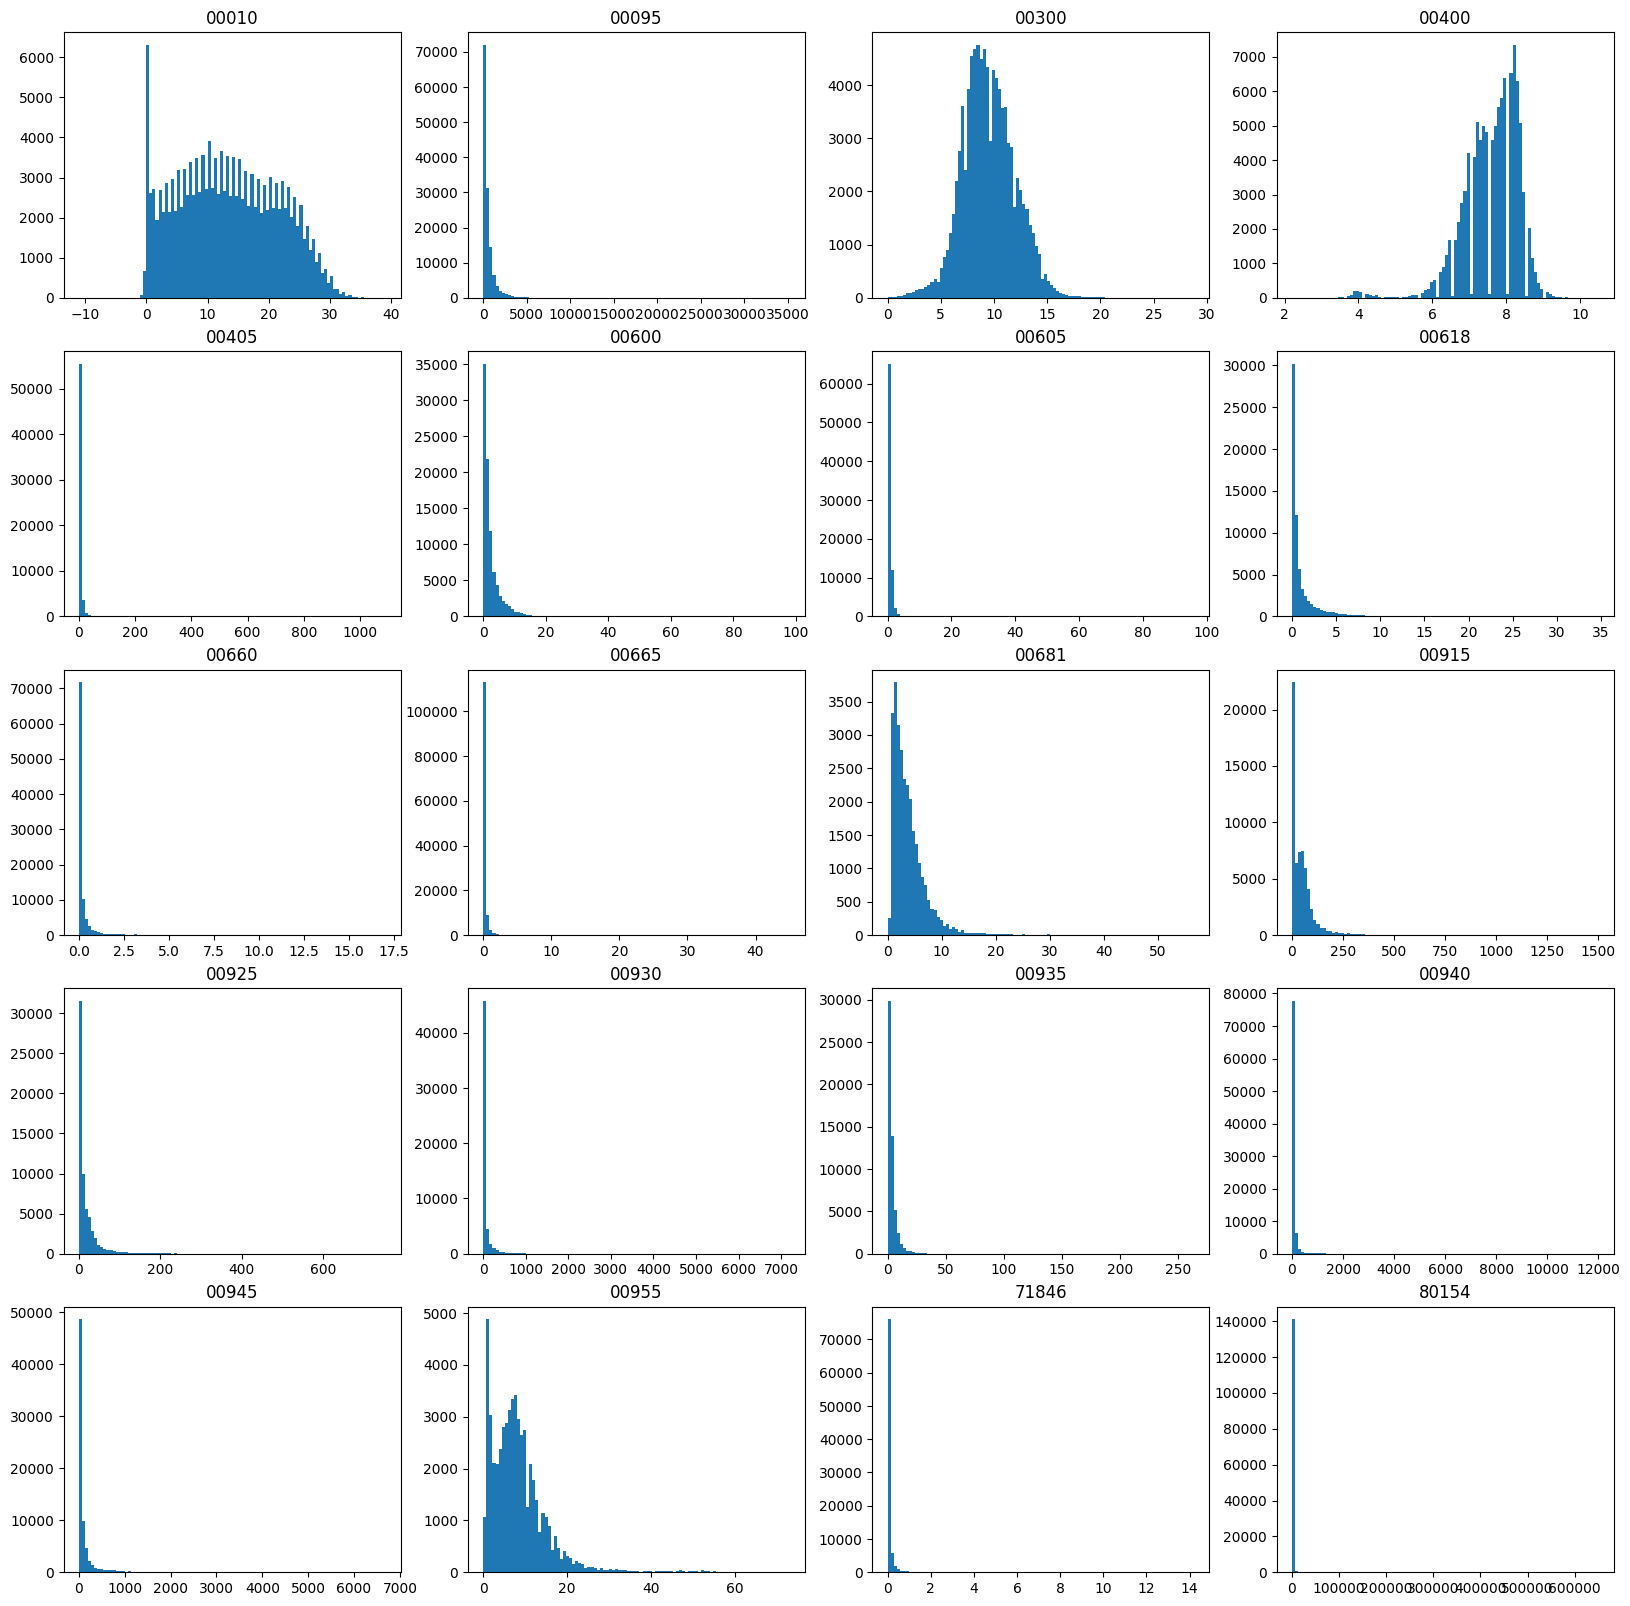

In [32]:
# plot a histogram of every list in data_dict, put all the figures into a large figure
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
for i, target in enumerate(targets):
    axs[i].hist(data_dict[target], bins=100)
    axs[i].set_title(target)
plt.show()

In [33]:
from mytransform import LogNormalize

def transform(x):
    # x is torch tensor
    # get the 10th percentile and 90th percentile of log(x)
    # clamp(1e-9) then log
    x = x.clamp(1e-8)
    x = torch.log(x)
    x_norm = (x - torch.mean(x)) / (torch.sqrt(torch.var(x)))
    # perc10 = torch.nanquantile(x, 0.10, dim=0, keepdim=True)
    # perc90 = torch.nanquantile(x, 0.90, dim=0, keepdim=True)
    # norm = LogNormalize(perc10, perc90)
    return x_norm

transformer = QuantileTransformer(output_distribution='uniform', random_state=0)

def transform1(x):
    # x is torch tensor
    # get the 10th percentile and 90th percentile of log(x)
    # clamp(1e-9) then log
    x = x.clamp(1e-9)
    # x = torch.log(x)
    x_norm = transformer.fit_transform(x.numpy().reshape(-1, 1))
    x_norm = torch.tensor(x_norm, dtype=torch.float32)
    return x_norm

# apply the transform to every list in data_dict
for target in targets:
    normalized_data_dict[target] = transform(torch.tensor(data_dict[target])).numpy()


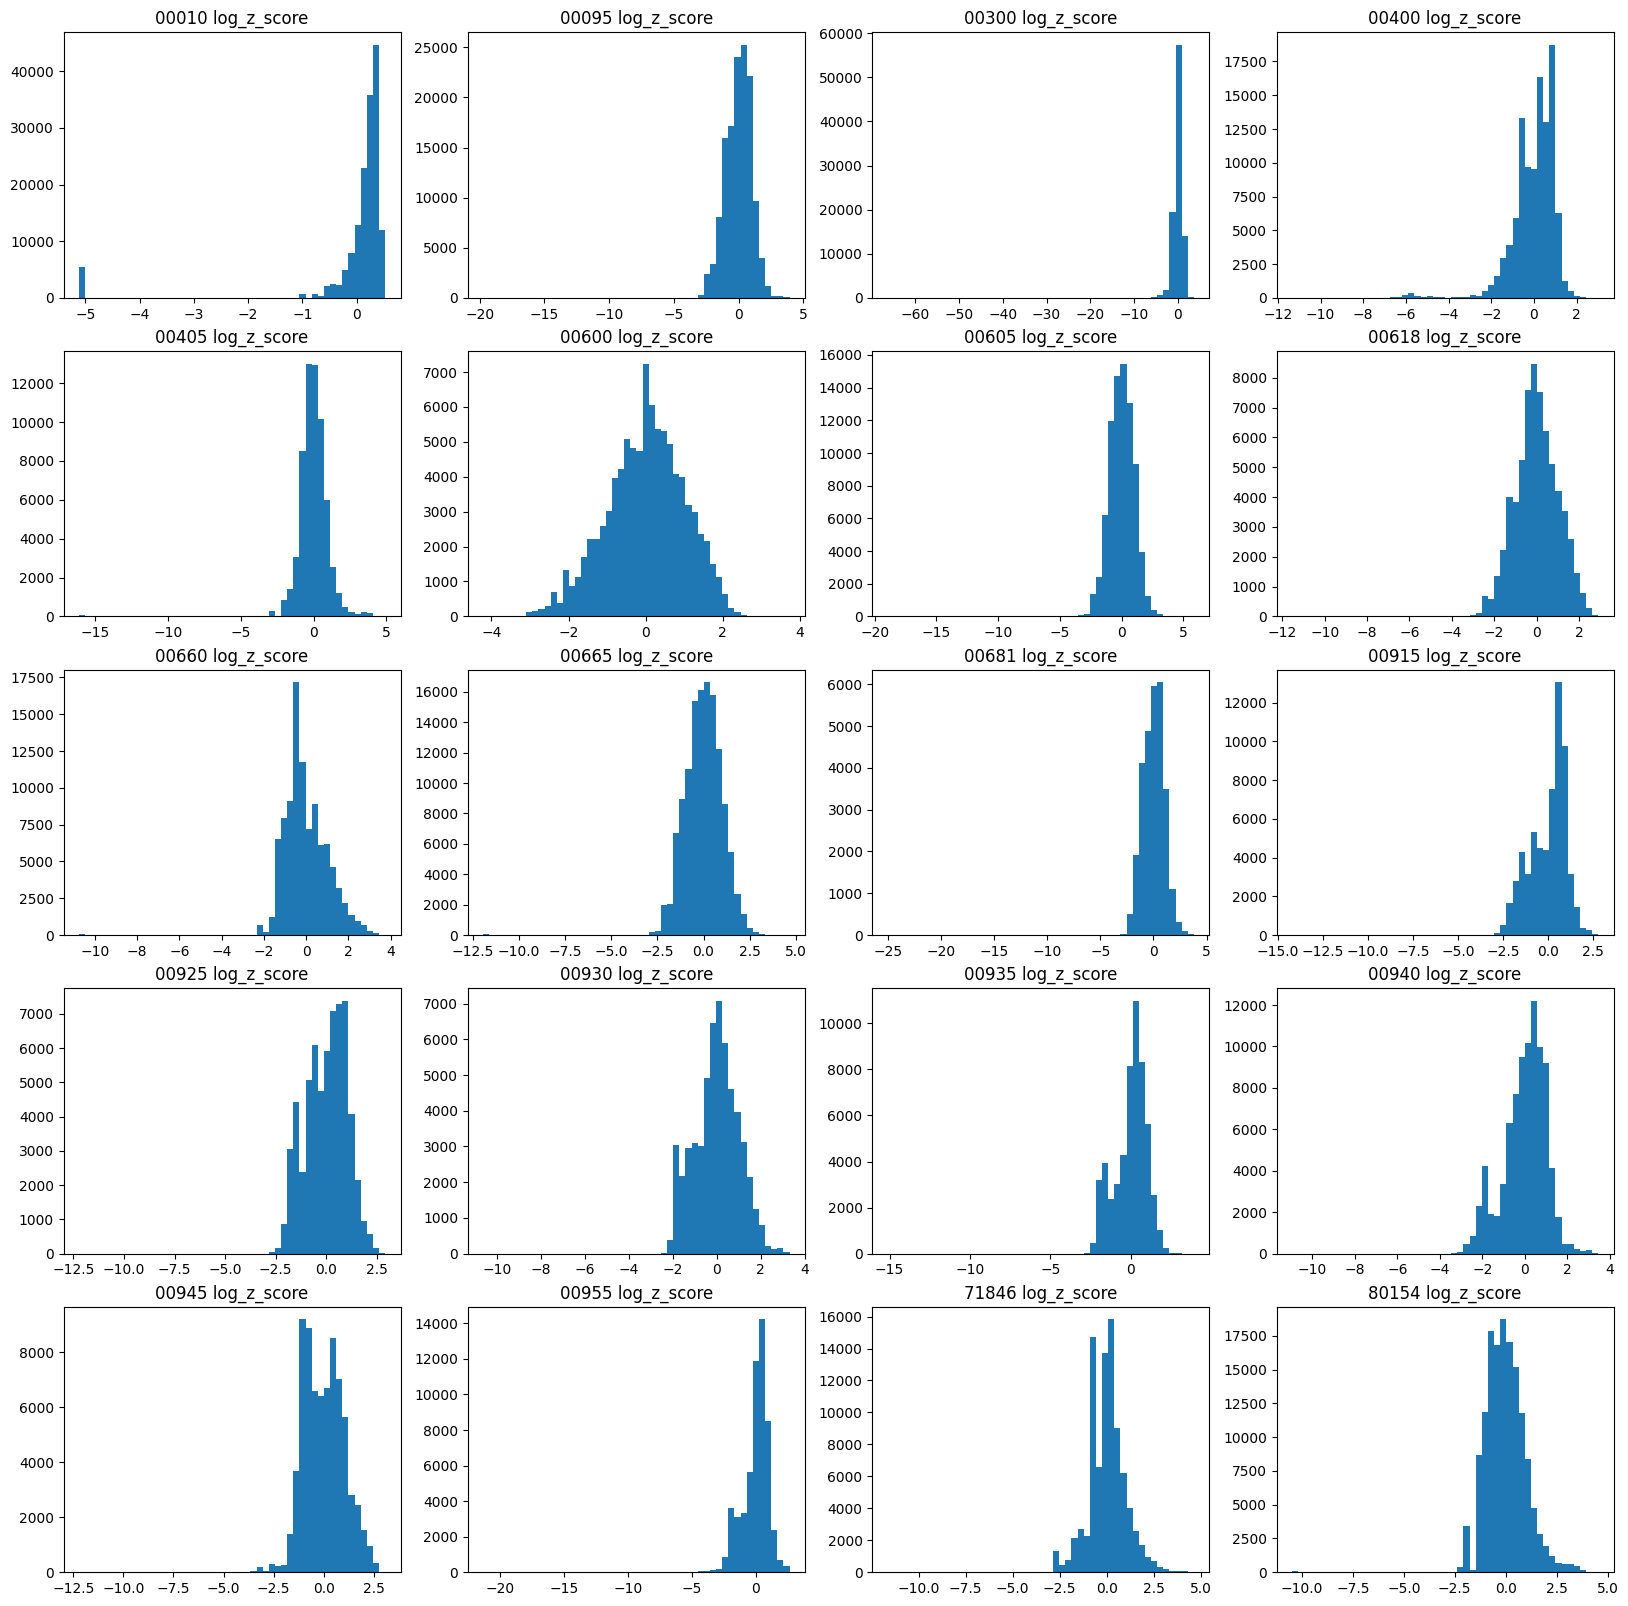

In [34]:
# plot a histogram of every list in data_dict, put all the figures into a large figure
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
for i, target in enumerate(targets):
    axs[i].hist(normalized_data_dict[target], bins=50)
    axs[i].set_title(f"{target} log_z_score")
plt.show()

In [35]:
import matplotlib.pyplot as plt

def draw_histogram(data1, data2, bins=50, title1='Histogram 1', title2='Histogram 2', xlabel='Value', ylabel='Count'):
    """
    Draws two histograms from two 1D numpy arrays and puts them into one figure.

    Parameters:
    - data1: 1D numpy array for the first histogram
    - data2: 1D numpy array for the second histogram
    - bins: Number of bins for the histograms (default is 10)
    - title1: Title of the first histogram (default is 'Histogram 1')
    - title2: Title of the second histogram (default is 'Histogram 2')
    - xlabel: Label for the x-axis (default is 'Value')
    - ylabel: Label for the y-axis (default is 'Count')
    """
    plt.figure(figsize=(12, 6))

    # First histogram
    plt.subplot(1, 2, 1)
    plt.hist(data1, bins=bins, edgecolor='black')
    plt.title(title1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    # Second histogram
    plt.subplot(1, 2, 2)
    plt.hist(data2, bins=bins, edgecolor='black')
    plt.title(title2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print(torch.mean(pr_norm), torch.std(pr_norm))
print(torch.mean(runoff_norm), torch.std(runoff_norm))

draw_histogram(pr_norm.numpy(), prs.numpy(), bins=50, title1='sph log transform', title2='sph', xlabel='Value', ylabel='Frequency')
draw_histogram(runoff_norm.numpy(), runoffs.numpy(), bins=50, title1='runoff log transform', title2='runoff', xlabel='Value', ylabel='Frequency')

NameError: name 'pr_norm' is not defined